# Spleen 3D segmentation with MONAI

Segmentation is a common task where the goal is to identify a particular object in an image (in this case, we will try to identify the spleen from abdominal CT). We will train a model to take as input a CT and return a label image where voxels inside the spleen are labeled 1 and others are labeled 0. The training data consists of CT images along with hand-segmented label images.

We will be making use of [MONAI](https://monai.io/), a PyTorch-based framework for deep learning in medical imaging being developed by, among others, NVIDIA and Kitware. This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program and use the following features:
1. Create transforms for dictionary format data.
1. Load Nifti images with metadata.
1. Add a channel dim to the data if no channel dimension.
1. Scale medical image intensity.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. Create a 3D UNet model with a Dice loss function for 3D segmentation.
1. Use a sliding window inference method.
1. Deterministic training for reproducibility.

## You should run this notebook with GPU hardware acceleration. On Google Colab, you can go to Edit -> Notebook Settings and select GPU to enable this.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/ais2-tutorials/blob/master/notebooks/spleen_segmentation_3d.ipynb)

This tutorial was adapted from one in the [official MONAI tutorials repository](https://github.com/Project-MONAI/tutorials).

## Setup environment

In [1]:
%pip install -q "monai[gdown, nibabel, tqdm]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup some imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch


from monai.config import print_config

print_config()

MONAI version: 0.6.0
Numpy version: 1.21.1
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 3.13.0
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.62.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.1
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpda2n45do


## Download dataset

We will download the Spleen dataset from http://medicaldecathlon.com/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

This is a 1.61GB download and could take several minutes.

In [5]:
# Download and extract the dataset 
from monai.apps import download_and_extract

resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [04:06, 6.52MB/s]                                     


Downloaded: /tmp/tmpda2n45do/Task09_Spleen.tar
Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
Writing into directory: /tmp/tmpda2n45do.


## Set MSD Spleen dataset path

Split the data (CT images in imagesTr, label images in labelsTr) into training and validation data.

In [6]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [7]:
from monai.utils import set_determinism

set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `Orientationd` unifies the data orientation (in this case using RAS).
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `ToTensord` converts the numpy array to PyTorch Tensor for further steps.

In [8]:
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0, spatial_size=(96, 96, 96),
        #             rotate_range=(0, 0, np.pi/15), scale_range=(0.1, 0.1, 0.1)),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

## Check transforms by visualizing images via DataLoader

image shape: torch.Size([226, 157, 113]), label shape: torch.Size([226, 157, 113])


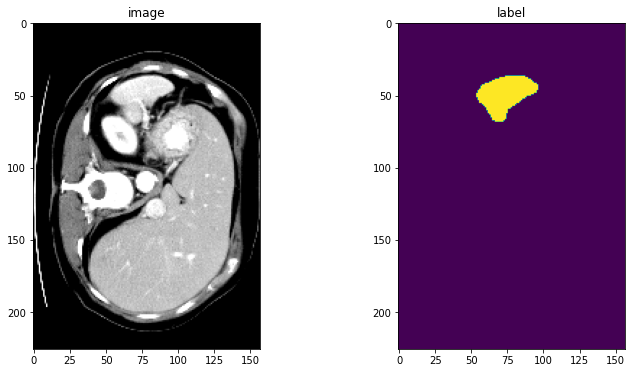

In [9]:
from monai.data import DataLoader, Dataset
from monai.utils import first

# Load an image from the validation set
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate the training and validation process. It's faster than the regular Dataset because it caches the results of non-random transforms applied to the data.  

To achieve best performance, set `cache_rate=1.0` to cache all the data. If there is not enough memory, set a lower value.   

Users can also set `cache_num` instead of `cache_rate` to cache a specific number of images. The minimum value of the 2 settings will be used. You can also set `num_workers` to enable multiple threads during caching.  

Building the cache can take a couple of minutes.

If want to to try the regular Dataset, just change to use the commented code below.

In [10]:
from monai.data import CacheDataset

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|████████████████████████████| 9/9 [00:06<00:00,  1.33it/s]


## Create Model, Loss, Optimizer

For the model we are using U-Net, a popular architecture for both 2D and 3D image segmentation. It is a convolutional network named for its shape (see below) and is a popular choice for medical applications because it generally requires less training data than other segmentation approaches. See [this paper](https://arxiv.org/abs/1505.04597) for more information.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="512">

For loss we are using [Dice](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient), which is a measure of overlap between the estimated and target segmentations. Dice does not work well for all types of objects, such as thin objects were small changes in the object lead to large changes in overlap, but it should work well for the spleen.

In [11]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.networks.layers import Norm

device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

## Execute a typical PyTorch training process

Normally, this would be run for a large number of epochs until the loss starts to converge, which could take quite a while depending on the hardware it is running on. We will use a smaller number (50) here to demonstrate the training process and see some intermediate results. Later we will load a fully trained model to see how the results can improve after further training.

If you'd rather run the full training yourself, change `epoch_num` below to 600.

In [12]:
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.transforms import AsDiscrete

epoch_num = 50
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
post_pred = AsDiscrete(argmax=True,to_onehot=True,n_classes=2)
post_label = AsDiscrete(to_onehot=True,n_classes=2)

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    
    # Training step
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    # Validation step
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            
            # Save the current best model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

----------
epoch 1/50
1/16, train_loss: 0.6764
2/16, train_loss: 0.6668
3/16, train_loss: 0.6652
4/16, train_loss: 0.6722
5/16, train_loss: 0.6516
6/16, train_loss: 0.6677
7/16, train_loss: 0.6541
8/16, train_loss: 0.6686
9/16, train_loss: 0.6717
10/16, train_loss: 0.6597
11/16, train_loss: 0.6411
12/16, train_loss: 0.6550
13/16, train_loss: 0.6427
14/16, train_loss: 0.6479
15/16, train_loss: 0.6413
16/16, train_loss: 0.6506
epoch 1 average loss: 0.6583
----------
epoch 2/50
1/16, train_loss: 0.6439
2/16, train_loss: 0.6366
3/16, train_loss: 0.6388
4/16, train_loss: 0.6130
5/16, train_loss: 0.6187
6/16, train_loss: 0.6046
7/16, train_loss: 0.6183
8/16, train_loss: 0.6147
9/16, train_loss: 0.6363
10/16, train_loss: 0.6235
11/16, train_loss: 0.6031
12/16, train_loss: 0.6339
13/16, train_loss: 0.6450
14/16, train_loss: 0.6373
15/16, train_loss: 0.6273
16/16, train_loss: 0.6241
epoch 2 average loss: 0.6262
saved new best metric model
current epoch: 2 current mean dice: 0.4980
best mean dic

8/16, train_loss: 0.5281
9/16, train_loss: 0.5164
10/16, train_loss: 0.5080
11/16, train_loss: 0.5398
12/16, train_loss: 0.5317
13/16, train_loss: 0.5197
14/16, train_loss: 0.4606
15/16, train_loss: 0.4686
16/16, train_loss: 0.5459
epoch 17 average loss: 0.5130
----------
epoch 18/50
1/16, train_loss: 0.4565
2/16, train_loss: 0.5133
3/16, train_loss: 0.5092
4/16, train_loss: 0.5296
5/16, train_loss: 0.5473
6/16, train_loss: 0.4921
7/16, train_loss: 0.4670
8/16, train_loss: 0.4633
9/16, train_loss: 0.4987
10/16, train_loss: 0.4744
11/16, train_loss: 0.5156
12/16, train_loss: 0.5305
13/16, train_loss: 0.5756
14/16, train_loss: 0.4501
15/16, train_loss: 0.5221
16/16, train_loss: 0.5487
epoch 18 average loss: 0.5059
current epoch: 18 current mean dice: 0.4980
best mean dice: 0.4980 at epoch: 2
----------
epoch 19/50
1/16, train_loss: 0.5010
2/16, train_loss: 0.5356
3/16, train_loss: 0.5554
4/16, train_loss: 0.4338
5/16, train_loss: 0.5135
6/16, train_loss: 0.4750
7/16, train_loss: 0.4513
8

16/16, train_loss: 0.4759
epoch 33 average loss: 0.3962
----------
epoch 34/50
1/16, train_loss: 0.4550
2/16, train_loss: 0.4303
3/16, train_loss: 0.3481
4/16, train_loss: 0.3476
5/16, train_loss: 0.4330
6/16, train_loss: 0.3332
7/16, train_loss: 0.3848
8/16, train_loss: 0.4505
9/16, train_loss: 0.3459
10/16, train_loss: 0.3483
11/16, train_loss: 0.3869
12/16, train_loss: 0.4025
13/16, train_loss: 0.3784
14/16, train_loss: 0.3939
15/16, train_loss: 0.4036
16/16, train_loss: 0.3837
epoch 34 average loss: 0.3891
current epoch: 34 current mean dice: 0.4980
best mean dice: 0.4980 at epoch: 2
----------
epoch 35/50
1/16, train_loss: 0.4347
2/16, train_loss: 0.3463
3/16, train_loss: 0.4690
4/16, train_loss: 0.3660
5/16, train_loss: 0.3550
6/16, train_loss: 0.3836
7/16, train_loss: 0.4496
8/16, train_loss: 0.3530
9/16, train_loss: 0.3510
10/16, train_loss: 0.3698
11/16, train_loss: 0.4744
12/16, train_loss: 0.3219
13/16, train_loss: 0.4134
14/16, train_loss: 0.4144
15/16, train_loss: 0.3613
1

6/16, train_loss: 0.3012
7/16, train_loss: 0.2610
8/16, train_loss: 0.2789
9/16, train_loss: 0.2756
10/16, train_loss: 0.3104
11/16, train_loss: 0.3917
12/16, train_loss: 0.2988
13/16, train_loss: 0.2948
14/16, train_loss: 0.2970
15/16, train_loss: 0.3383
16/16, train_loss: 0.3422
epoch 50 average loss: 0.3103
current epoch: 50 current mean dice: 0.4980
best mean dice: 0.4980 at epoch: 2


In [13]:
print(f"train completed, best_metric: {best_metric:.4f}  at epoch: {best_metric_epoch}")

train completed, best_metric: 0.4980  at epoch: 2


## Plot the loss and metric

Here we can see how the loss function is changing over time and how the model is performing on the vaidation set. 

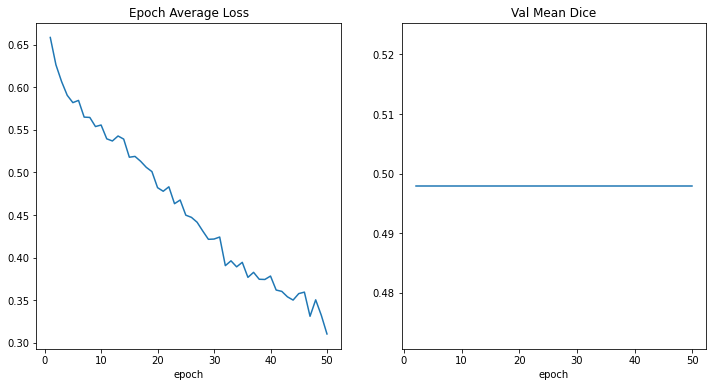

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Compare output of the best model with ground truth

If you ran with 50 epochs above, these results will show that the model is starting to learn where the spleen is but many cases will still have strange errors. This is an indicator that the model is on track but needs more training.

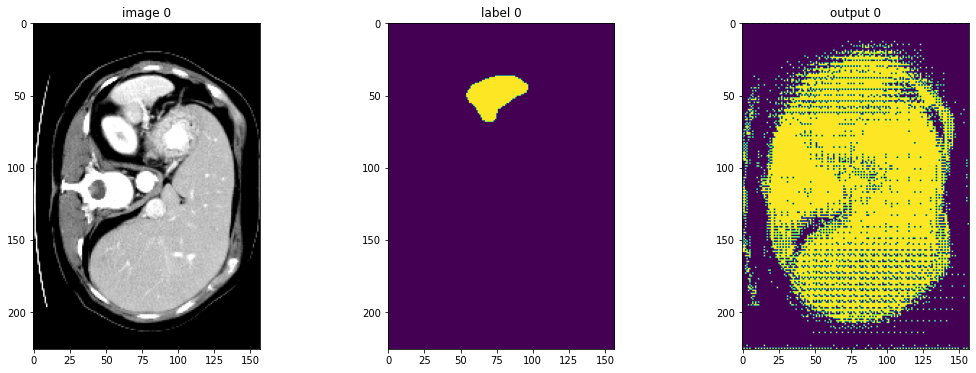

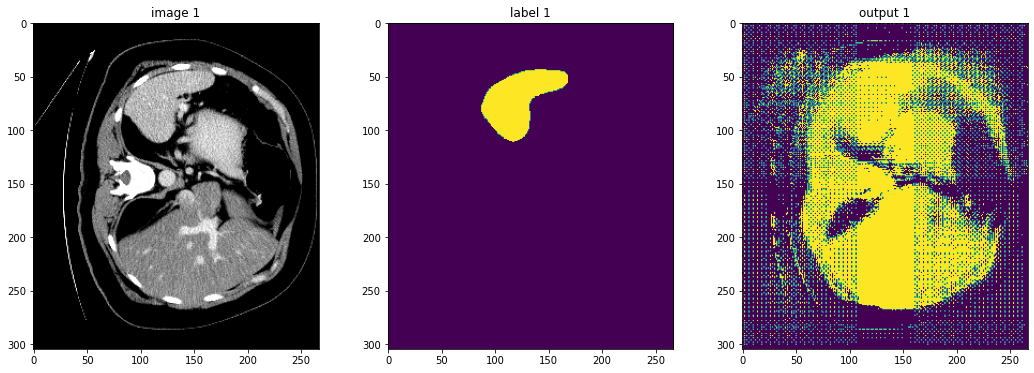

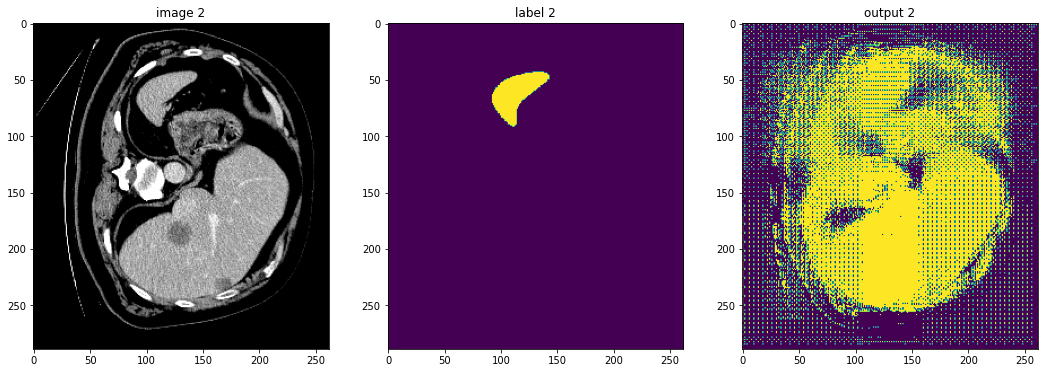

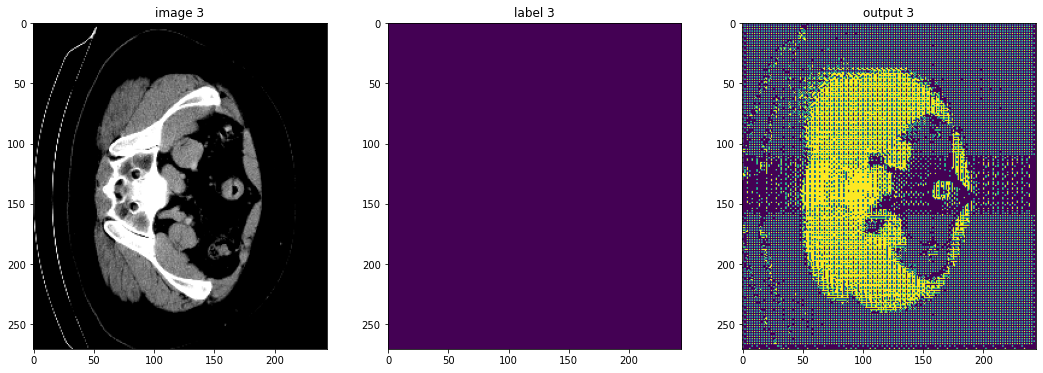

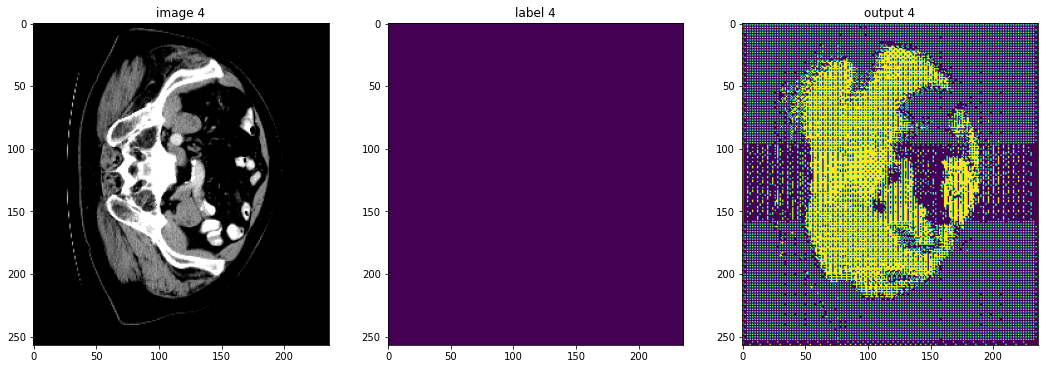

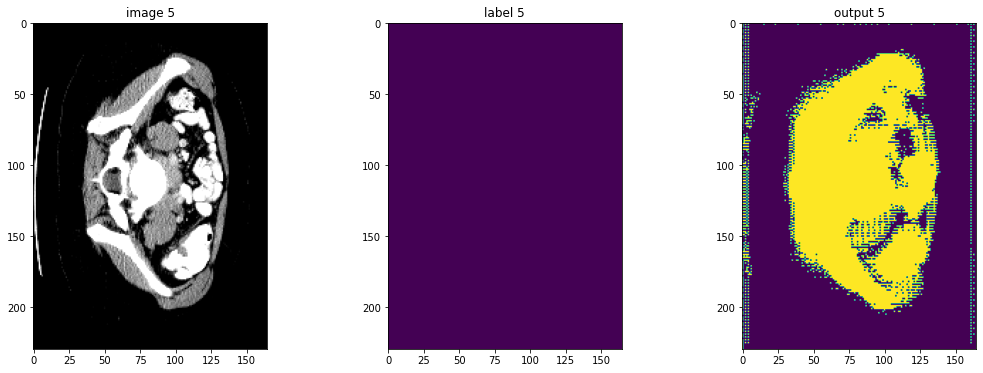

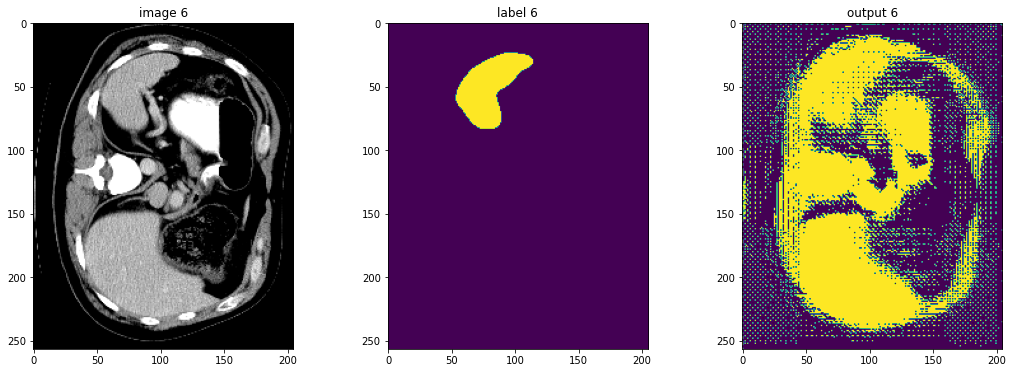

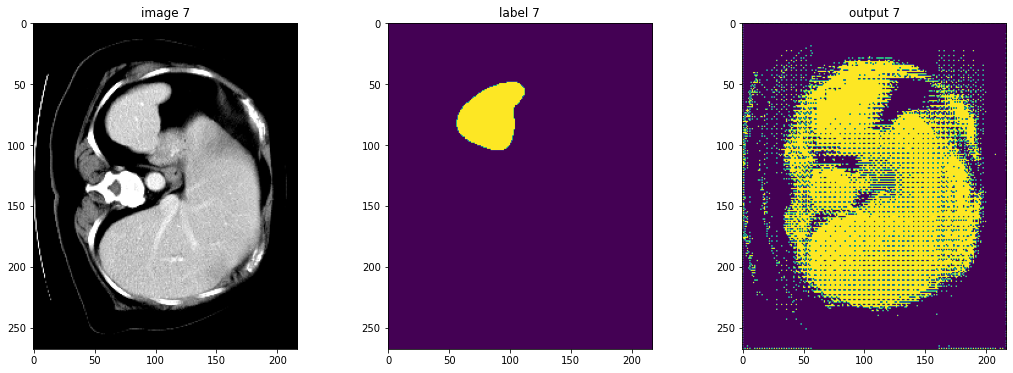

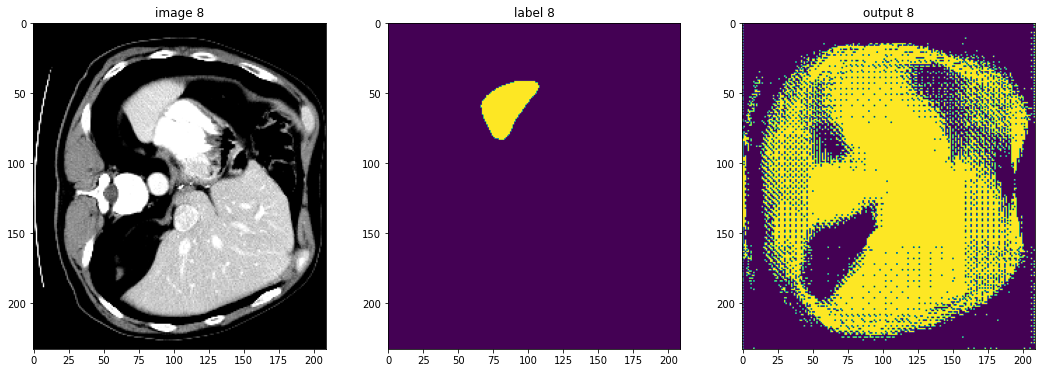

In [15]:
def visualize_model(model):
    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(
                val_data["image"].to(device), roi_size, sw_batch_size, model
            )
            # plot the slice [:, :, 80]
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            plt.imshow(val_data["label"][0, 0, :, :, 80])
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
            plt.show()
        
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
visualize_model(model)


## Download a fully trained model and see full training results

This model was trained for 600 epochs on the same dataset. By that point the loss will have leveled off and validation error will be small.

full_train.pth: 18.4MB [00:03, 5.22MB/s]


Downloaded: /tmp/tmpda2n45do/full_train.pth
Verified 'full_train.pth', md5: 8049059a15f248e0f4209ba37ec89119.


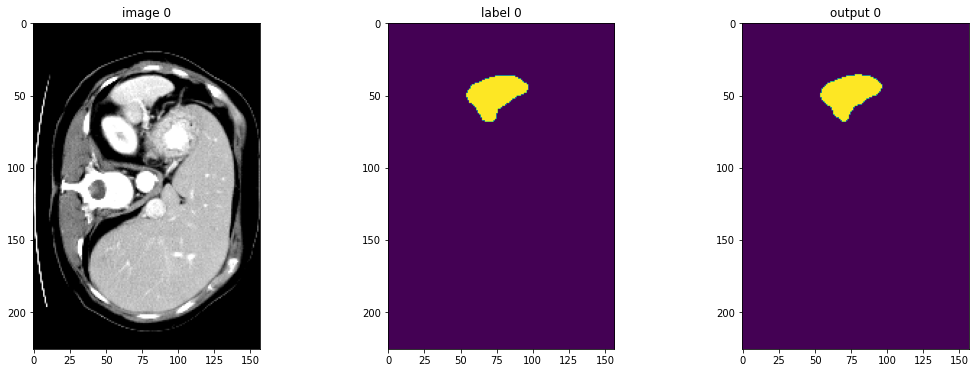

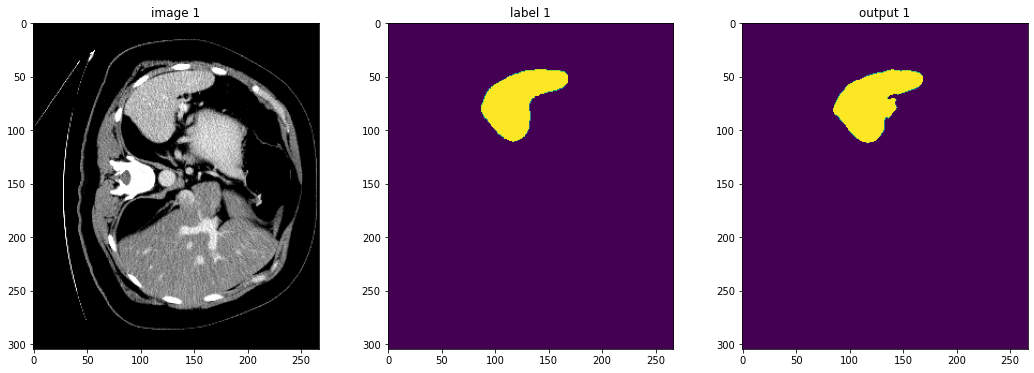

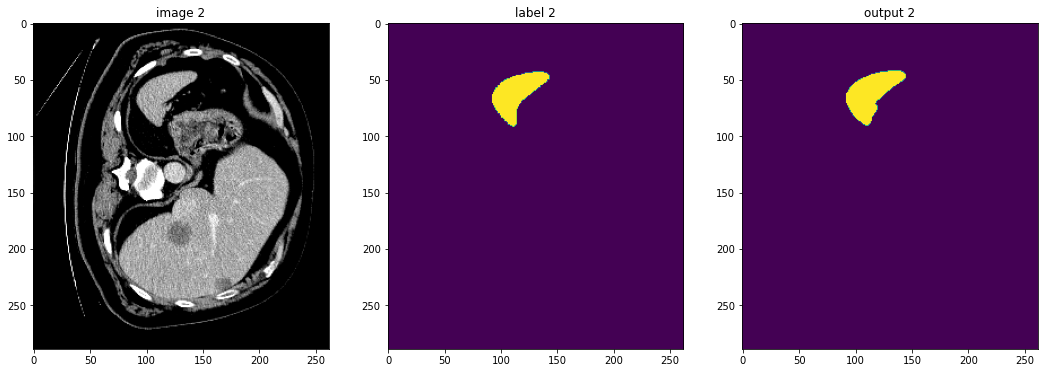

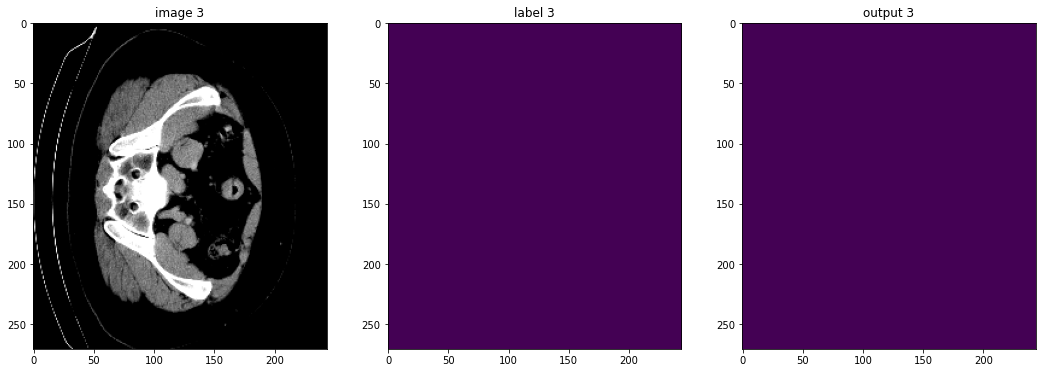

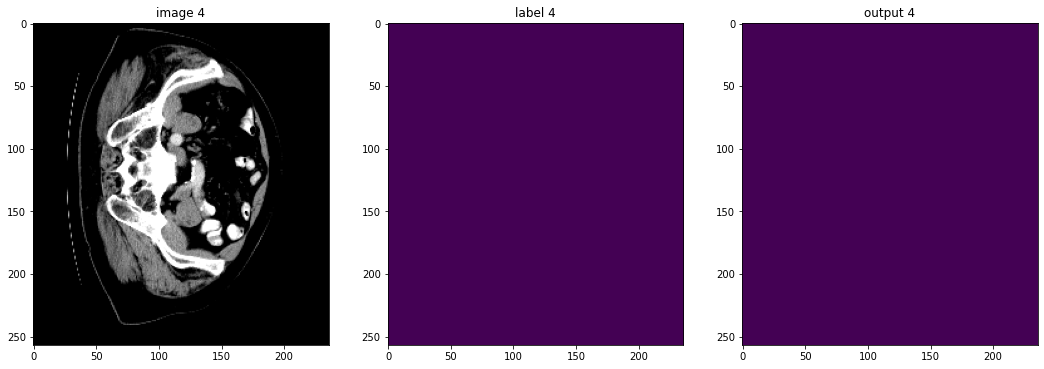

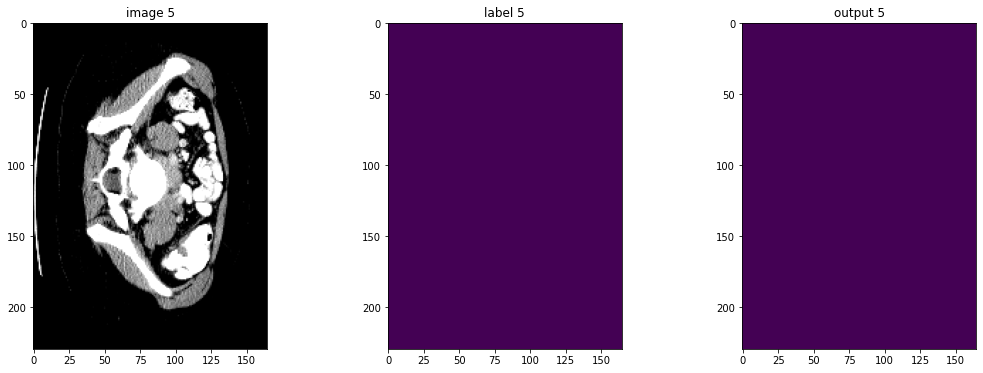

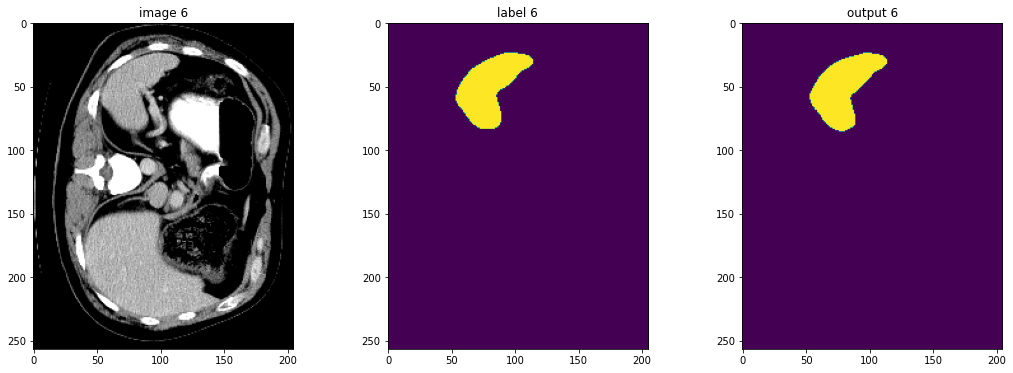

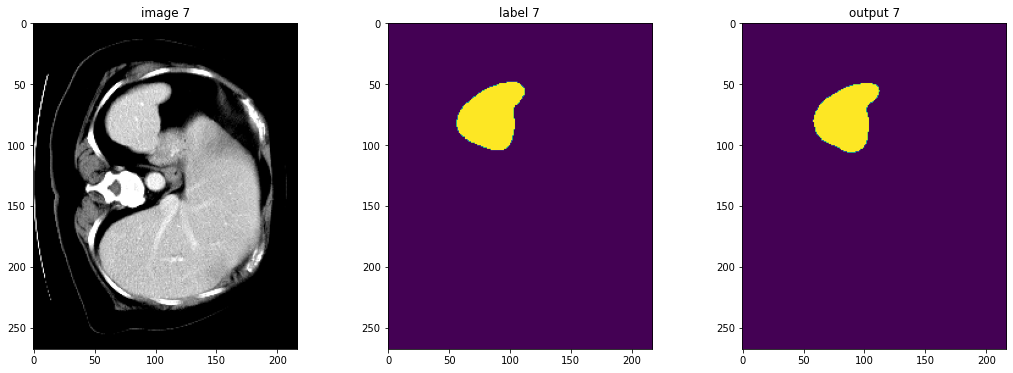

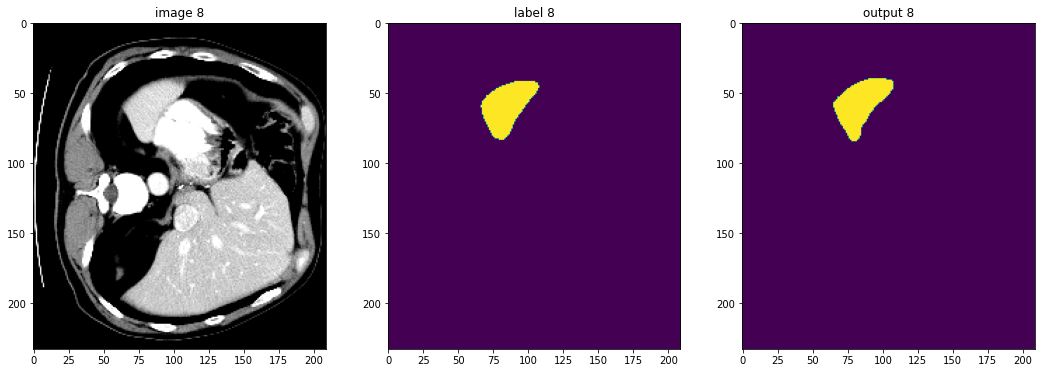

In [16]:
from monai.apps import download_url

resource = "http://drive.google.com/uc?id=1y4R8zYKl3rnUDhQvPuv4tMskGFmhndtw"
md5 = "8049059a15f248e0f4209ba37ec89119"

model_file = os.path.join(root_dir, "full_train.pth")

if not os.path.exists(model_file):
    download_url(resource, model_file, md5)

model.load_state_dict(torch.load(os.path.join(root_dir, model_file)))
model.eval()
visualize_model(model)


## Cleanup data directory

Remove directory if a temporary was used.

In [17]:
if directory is None:
    shutil.rmtree(root_dir)